In [ ]:
!git clone https://github.com/rmnigm/qber-forecasting.git
!pip install --force-reinstall etna[all]==1.15.1 torch==1.11.0 tsfresh==0.20.0 protobuf==3.20.3 gdown==4.6.4

In [2]:
import os
import random
import sys
import warnings

import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer

from etna.analysis import (cross_corr_plot, distribution_plot, plot_anomalies,
                           plot_anomalies_interactive, plot_backtest,
                           plot_correlation_matrix, plot_forecast,
                           acf_plot, get_residuals,
                           plot_residuals)
from etna.analysis.outliers import (get_anomalies_density, get_anomalies_hist,
                                    get_anomalies_median,
                                    get_anomalies_prediction_interval)
from etna.datasets import TSDataset
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.metrics import MAE, MAPE, MSE, SMAPE
from etna.models import (CatBoostModelPerSegment, CatBoostMultiSegmentModel,
                         LinearPerSegmentModel, MovingAverageModel, NaiveModel,
                         ProphetModel, SeasonalMovingAverageModel, SimpleExpSmoothingModel)
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.transforms import (DateFlagsTransform, FilterFeaturesTransform,
                             HolidayTransform, LagTransform,
                             LinearTrendTransform, LogTransform, MeanTransform,
                             MedianOutliersTransform, SegmentEncoderTransform,
                             TimeSeriesImputerTransform)

In [3]:
warnings.filterwarnings("ignore")

In [7]:
pulses_stats_file_path = "/content/qber-forecasting/datasets/data.csv"
dataframe = pd.read_csv(pulses_stats_file_path,
                        usecols=range(1, 8),
                        engine='python',
                        )
dataframe = dataframe[:100000]

In [8]:
dataframe['timestamp'] = range(len(dataframe))
dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], unit='s')
dataframe['target'] = dataframe['e_mu_current']
dataframe['segment'] = 'main'

features = [
    'e_mu_estimated',
    'e_nu_1',
    'e_nu_2',
    'q_mu',
    'q_nu1',
    'q_nu2'
    ]

In [9]:
dataframe.head()

,e_mu_current,e_mu_estimated,e_nu_1,e_nu_2,q_mu,q_nu1,q_nu2,timestamp,target,segment
0,0.01298,0.01164,0.01904,0.17794,0.550377,0.164911,0.008094,1970-01-01 00:00:00,0.01298,main
1,0.01283,0.00961,0.01672,0.20868,0.564295,0.167629,0.006639,1970-01-01 00:00:01,0.01283,main
2,0.01268,0.00590,0.01337,0.20442,0.564179,0.164110,0.007052,1970-01-01 00:00:02,0.01268,main
3,0.01129,0.00988,0.01637,0.18453,0.573555,0.167174,0.006663,1970-01-01 00:00:03,0.01129,main
4,0.01169,0.01338,0.01783,0.11478,0.569296,0.169658,0.006823,1970-01-01 00:00:04,0.01169,main


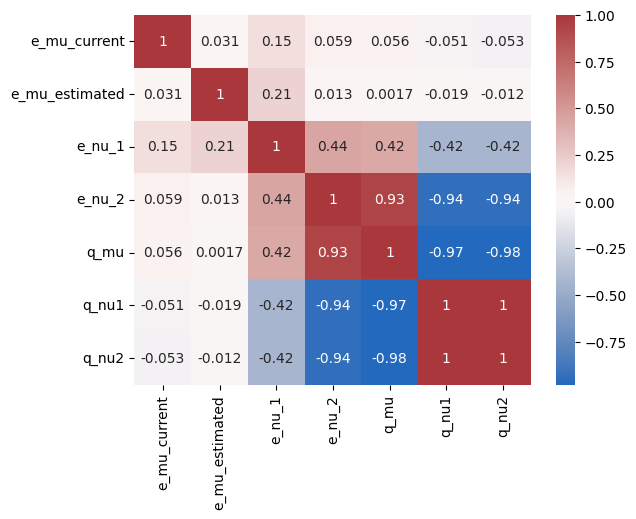

In [28]:
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(dataframe.drop(columns=['target']).corr("pearson"),
            annot=True,
            cmap=cmap
            )
plt.show()

In [10]:
dataset = TSDataset.to_dataset(dataframe[['timestamp', 'segment', 'target']][:-1])
dataset_exog = TSDataset.to_dataset(dataframe.drop(columns=['e_mu_current', 'target']))

In [36]:
ts = TSDataset(df=dataset, df_exog=dataset_exog, known_future='all', freq='S')
ts

segment                       main                                        \
feature             e_mu_estimated   e_nu_1   e_nu_2      q_mu     q_nu1   
timestamp                                                                  
1970-01-01 00:00:00        0.01164  0.01904  0.17794  0.550377  0.164911   
1970-01-01 00:00:01        0.00961  0.01672  0.20868  0.564295  0.167629   
1970-01-01 00:00:02        0.00590  0.01337  0.20442  0.564179  0.164110   
1970-01-01 00:00:03        0.00988  0.01637  0.18453  0.573555  0.167174   
1970-01-01 00:00:04        0.01338  0.01783  0.11478  0.569296  0.169658   
...                            ...      ...      ...       ...       ...   
1970-01-02 03:46:34        0.01248  0.01962  0.19760  0.565882  0.175590   
1970-01-02 03:46:35        0.01032  0.01709  0.18510  0.563265  0.171382   
1970-01-02 03:46:36        0.01084  0.01928  0.22052  0.570781  0.167541   
1970-01-02 03:46:37        0.01277  0.01847  0.16053  0.567416  0.171768   
1970-01-02 03:46:38        0.00996  0.01779  0.19255  0.567669  0.168840   

segment                                 
feature                 q_nu2   target  
timestamp                               
1970-01-01 00:00:00  0.008094  0.01298  
1970-01-01 00:00:01  0.006639  0.01283  
1970-01-01 00:00:02  0.007052  0.01268  
1970-01-01 00:00:03  0.006663  0.01129  
1970-01-01 00:00:04  0.006823  0.01169  
...                       ...      ...  
1970-01-02 03:46:34  0.007531  0.01312  
1970-01-02 03:46:35  0.007331  0.01199  
1970-01-02 03:46:36  0.007596  0.01114  
1970-01-02 03:46:37  0.006801  0.01290  
1970-01-02 03:46:38  0.008139  0.01184  

[99999 rows x 7 columns]

In [33]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,1970-01-01,1970-01-02 03:46:38,99999,0,1,6,6,6,S


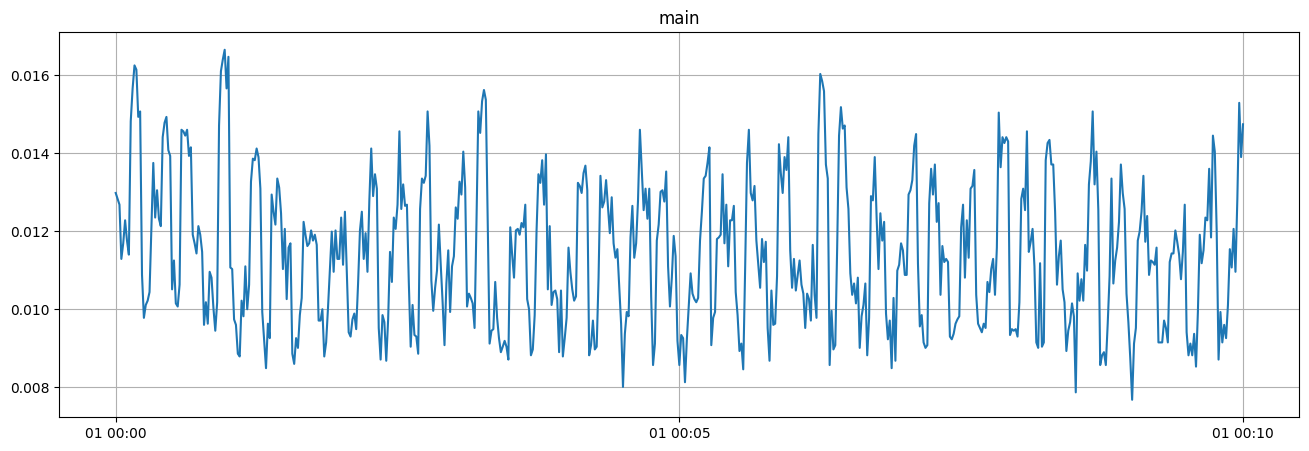

In [34]:
ts.plot(start='1970-01-01', end='1970-01-01 00:10:00', figsize=(16, 5))

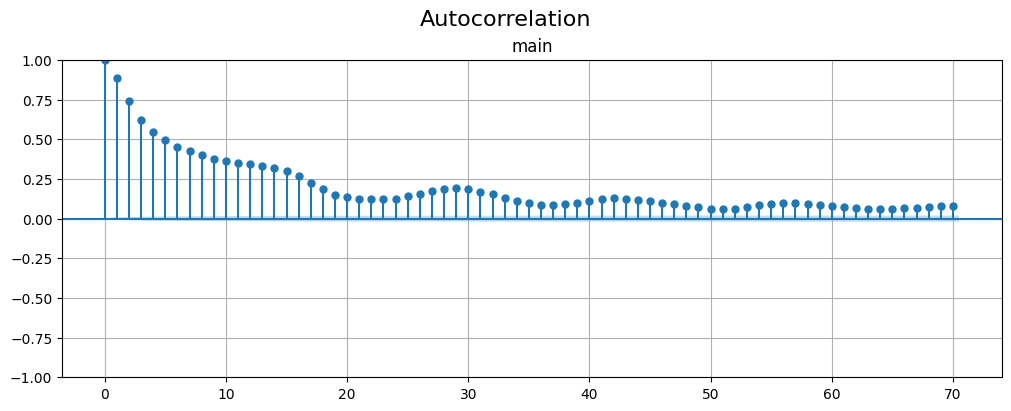

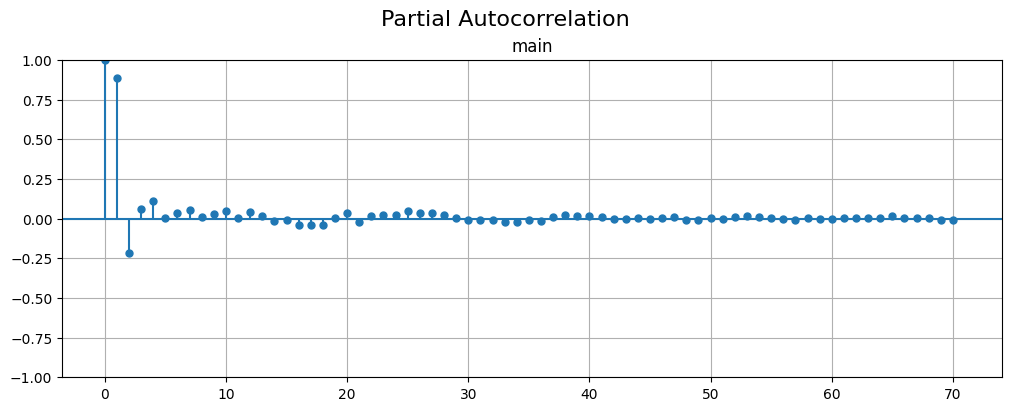

In [40]:
acf_plot(ts, lags=70, figsize=(10, 4))
acf_plot(ts, lags=70, partial=True, figsize=(10, 4))

In [17]:
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel)
from etna.transforms import LagTransform

In [41]:
lags = [LagTransform(in_column=col, lags=range(1, 50)) for col in features + ['target']]

In [43]:
HORIZON = 5

In [44]:
pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=lags,
    horizon=HORIZON,
    )

metrics, forecast, _ = pipeline.backtest(
    ts=ts,
    metrics=[MAPE(), MSE(), SMAPE()],
    n_folds=5,
    n_jobs=2,
    aggregate_metrics=True
)
metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  9.1min
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:  9.1min
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed: 18.0min remaining: 12.0min
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 22.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 22.7min finished


,segment,MAPE,MSE,SMAPE
0,main,12.365531,0.000003,13.12967


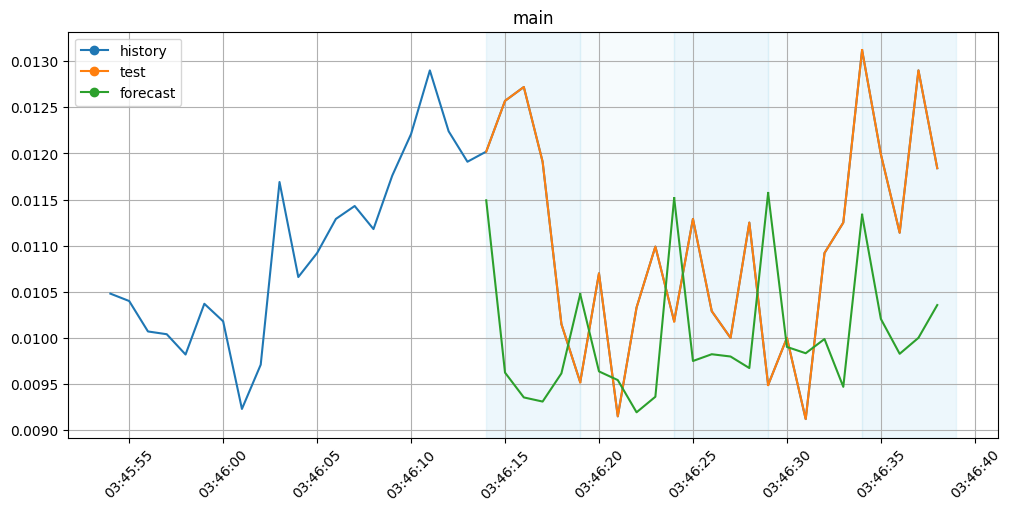

In [45]:
plot_backtest(forecast_df=forecast, ts=ts, history_len=20)

In [46]:
pipeline = Pipeline(
    model=ProphetModel(),
    horizon=HORIZON,
    )

prophet_metrics, prophet_forecast, _ = pipeline.backtest(
    ts=ts,
    metrics=[MAPE(), MSE(), SMAPE()],
    n_folds=5,
    n_jobs=2,
    aggregate_metrics=True
)
prophet_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnoyk06f_/4er5gy9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnoyk06f_/6ri7g7ph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnoyk06f_/dgz3nvks.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

,segment,MAPE,MSE,SMAPE
0,main,8.804217,0.000001,8.624337


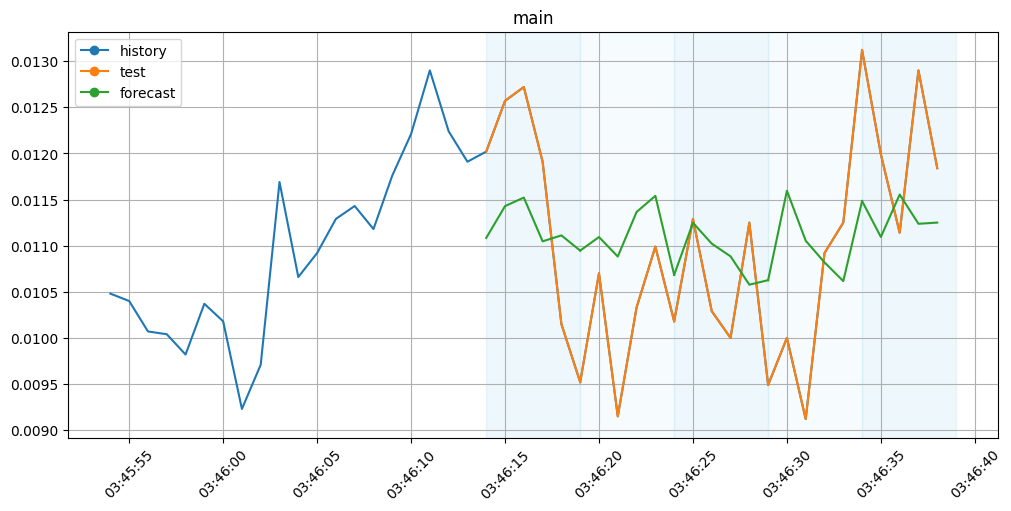

In [47]:
plot_backtest(forecast_df=prophet_forecast, ts=ts, history_len=20)